- Emma Rey Sánchez - 202110801
- Catalina Royo-Villanova Seguí - 202104665
# Proyecto Final

## Calibración de la cámara

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [15]:
def load_calibration_params(file_path):
    calibration_data = np.load(file_path)
    camera_matrix = calibration_data['mtx']
    dist_coeffs = calibration_data['dist']
    return camera_matrix, dist_coeffs

def undistort_image(image, camera_matrix, dist_coeffs):
    h, w = image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
    return undistorted_image

def encontrar_matches(img1, img2):
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.60*n.distance:
            good.append([m])
    return good, kp1, kp2


def objeto_en_frame(frame, templates):
    matriz_matches = list()
    for i in range(len(templates)):
        matriz_matches.append([i, encontrar_matches(frame, templates[i])])
    matches = [list(), None, None]
    producto = -1
    for i in matriz_matches:
        if len(matches[0]) < len(i[1][0]) and len(i[1][0]) > 20:
            matches = i[1]
            producto = i[0]
    return producto, matches


def dibujar_rectangulo(frame, templates):
    producto, matches_list = objeto_en_frame(frame, templates)
    if producto != -1:
        template = templates[producto]
        matches = matches_list[0]
        kp_frame = matches_list[1]
        kp_template = matches_list[2]
        # Obtener las coordenadas de los keypoints en el frame y el template
        pts_frame = np.float32([kp_frame[m[0].queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        pts_template = np.float32([kp_template[m[0].trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
        # Calcular la homografía entre el frame y el template
        M, _ = cv2.findHomography(pts_template, pts_frame, cv2.RANSAC, 5.0)
    
        # Obtener las esquinas del rectángulo del template
        h, w = template.shape
        pts_template_rect = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    
        # Transformar las esquinas del template al espacio del frame
        pts_frame_rect = cv2.perspectiveTransform(pts_template_rect, M)
    
        # Dibujar el rectángulo alrededor del objeto en el frame
        frame = cv2.polylines(frame, [np.int32(pts_frame_rect)], True, (0, 255, 0), 2)

    return frame, producto

[[< cv2.DMatch 0000026701636A70>], [< cv2.DMatch 0000026701636B70>], [< cv2.DMatch 0000026701636BB0>], [< cv2.DMatch 0000026701636C30>], [< cv2.DMatch 0000026701636C70>], [< cv2.DMatch 0000026701636CF0>], [< cv2.DMatch 0000026701636D70>], [< cv2.DMatch 0000026701636DB0>], [< cv2.DMatch 0000026701636DF0>], [< cv2.DMatch 0000026701636EB0>], [< cv2.DMatch 0000026701636EF0>], [< cv2.DMatch 00000267016370B0>], [< cv2.DMatch 00000267016371B0>], [< cv2.DMatch 0000026701637270>], [< cv2.DMatch 00000267016372F0>], [< cv2.DMatch 0000026701637330>], [< cv2.DMatch 0000026701637470>], [< cv2.DMatch 00000267016374B0>], [< cv2.DMatch 00000267016374F0>], [< cv2.DMatch 0000026701637570>], [< cv2.DMatch 00000267016375B0>], [< cv2.DMatch 00000267016375F0>], [< cv2.DMatch 0000026701637630>], [< cv2.DMatch 0000026701637730>], [< cv2.DMatch 0000026701637770>], [< cv2.DMatch 00000267016377B0>], [< cv2.DMatch 0000026701637970>], [< cv2.DMatch 00000267016379B0>], [< cv2.DMatch 0000026701637AB0>], [< cv2.DMatch

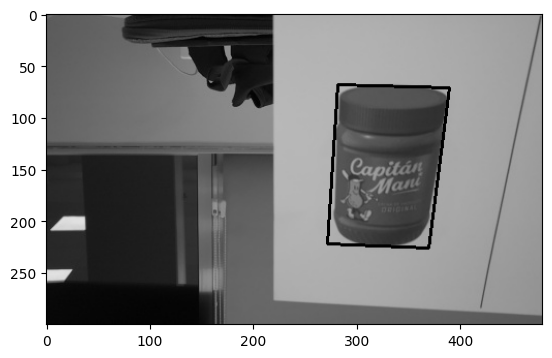

In [19]:
imgN = cv2.imread('ImagenesObjetos/Nutella.jpg',cv2.IMREAD_GRAYSCALE)
imgM = cv2.imread('ImagenesObjetos/Mermelada.jpg',cv2.IMREAD_GRAYSCALE)
imgC = cv2.imread('ImagenesObjetos/Cacahuete.jpg',cv2.IMREAD_GRAYSCALE)
fotos = [imgN, imgM, imgC]
img2 = cv2.imread('Imagen_cacahuete2.jpg',cv2.IMREAD_GRAYSCALE)

frame, producto = dibujar_rectangulo(img2, fotos)


imagen_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(imagen_rgb)
plt.show()

In [1]:
def contar_objetos(calibration_file, templates):
    # Conectamos la camara y la configuramos
    picam = Picamera2()
    picam.preview_configuration.main.size = (500, 300)
    picam.preview_configuration.main.format = "RGB888"
    picam.preview_configuration.align()
    picam.configure("preview")
    picam.start()
    # Cargar parámetros de calibración
    camera_matrix, dist_coeffs = load_calibration_params(calibration_file)
    contador_productos = [0 for _ in range(len(templates))]
    flag_productos = [False for _ in range(len(templates))]
    contador = 0
    while True:
        frame = picam.capture_array()
        # Corregimos la distorsión
        undistorted_frame = undistort_image(frame, camera_matrix, dist_coeffs)
        undistorted_frame, producto = dibujar_rectangulo(undistorted_frame, templates)
        if producto == -1:
            if contador < 5:
                contador += 1
            else:
                flag_productos = [False for _ in range(len(templates))]
                contador = 0
        else:
            if not flag_productos[producto]:
                flag_productos = [False for _ in range(len(templates))]
                contador_productos[producto] += 1
                flag_productos = [producto] = True

        cv2.imshow("picam", undistorted_frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

In [ ]:
imgN = cv2.imread('ImagenesObjetos/Nutella.jpg',cv2.IMREAD_GRAYSCALE)
imgM = cv2.imread('ImagenesObjetos/Mermelada.jpg',cv2.IMREAD_GRAYSCALE)
imgC = cv2.imread('ImagenesObjetos/Cacahuete.jpg',cv2.IMREAD_GRAYSCALE)
templates = [imgN, imgM, imgC]